## Read the data

In [620]:
import pandas as pd

df = pd.read_excel('madrid_rent_data.xlsx')

df_original = df.__deepcopy__()

## Explore the data
df.head()

,Id,District,Address,Number,Area,Rent,Bedrooms,Sq.Mt,Floor,Outer,Elevator,Penthouse,Cottage,Duplex,Semidetached
0,1,Ciudad Lineal,Piso en Quintana,NaN,Quintana,1300,2.0,72,3.0,1.0,1.0,0,0,0,0
1,2,Ciudad Lineal,Piso en calle de Arturo Soria,NaN,Costillares,3000,5.0,260,2.0,1.0,1.0,0,0,0,0
2,3,Ciudad Lineal,Piso en calle de Vicente Muzas,4,Colina,1300,2.0,100,3.0,1.0,1.0,0,0,0,0
3,4,Ciudad Lineal,Piso en calle Badajoz,NaN,San Pascual,1600,3.0,120,4.0,1.0,1.0,0,0,0,0
4,5,Ciudad Lineal,Piso en calle de Nuestra Señora del Villar,9,Ventas,800,2.0,60,3.0,1.0,0.0,0,0,0,0


## Remove uneeded columns

In [621]:
df = df.drop(columns=['Address', 'Number', 'Area'])

df.head()

,Id,District,Rent,Bedrooms,Sq.Mt,Floor,Outer,Elevator,Penthouse,Cottage,Duplex,Semidetached
0,1,Ciudad Lineal,1300,2.0,72,3.0,1.0,1.0,0,0,0,0
1,2,Ciudad Lineal,3000,5.0,260,2.0,1.0,1.0,0,0,0,0
2,3,Ciudad Lineal,1300,2.0,100,3.0,1.0,1.0,0,0,0,0
3,4,Ciudad Lineal,1600,3.0,120,4.0,1.0,1.0,0,0,0,0
4,5,Ciudad Lineal,800,2.0,60,3.0,1.0,0.0,0,0,0,0


## Get the data types and replace null values

In [622]:
# Print data types
df.dtypes

Id                int64
District         object
Rent              int64
Bedrooms        float64
Sq.Mt             int64
Floor           float64
Outer           float64
Elevator        float64
Penthouse         int64
Cottage           int64
Duplex            int64
Semidetached      int64
dtype: object

In [623]:
# Check for null values
df.isnull().sum()

Id                0
District          0
Rent              0
Bedrooms         89
Sq.Mt             0
Floor           141
Outer           162
Elevator        133
Penthouse         0
Cottage           0
Duplex            0
Semidetached      0
dtype: int64

In [624]:
df['Bedrooms'] = df['Bedrooms'].fillna(df['Bedrooms'].mean())
df['Floor'] = df['Floor'].fillna(0)
df['Outer'] = df['Outer'].fillna(0.5)
df['Elevator'] = df['Elevator'].fillna(0.5)

## Separate labels and features

In [625]:
labels = df.pop('Id')
x = df

## Feature engineering

In [626]:
import numpy as np
# Add new features

CENTER_TITLE = 'Center'
NORTH_TITLE = 'North'
SOUTH_TITLE = 'South'

# Create a mapping from district to zone
district_zone_map = {
    'Centro': CENTER_TITLE,
    'Arganzuela': CENTER_TITLE,
    'Retiro': CENTER_TITLE,
    'Salamanca': CENTER_TITLE,
    'Chamartín': CENTER_TITLE,
    'Chamberí': CENTER_TITLE,
    'Moncloa': CENTER_TITLE,
    'Tetuán': CENTER_TITLE,

    'Fuencarral': NORTH_TITLE,
    'Hortaleza': NORTH_TITLE,
    'Barajas': NORTH_TITLE,
    'Ciudad Lineal': NORTH_TITLE,
    'San Blás': NORTH_TITLE,

    'Latina': SOUTH_TITLE,
    'Moratalaz': SOUTH_TITLE,
    'Puente Vallecas': SOUTH_TITLE,
    'Carabanchel': SOUTH_TITLE,
    'Usera': SOUTH_TITLE,
    'Vicálvaro': SOUTH_TITLE,
    'Villa de Vallecas': SOUTH_TITLE,
}

# Add the new 'Zone' column
x['Zone'] = x['District'].map(district_zone_map)
x = x.drop(columns=['District'])


In [627]:
x.head()

,Rent,Bedrooms,Sq.Mt,Floor,Outer,Elevator,Penthouse,Cottage,Duplex,Semidetached,Zone
0,1300,2.0,72,3.0,1.0,1.0,0,0,0,0,North
1,3000,5.0,260,2.0,1.0,1.0,0,0,0,0,North
2,1300,2.0,100,3.0,1.0,1.0,0,0,0,0,North
3,1600,3.0,120,4.0,1.0,1.0,0,0,0,0,North
4,800,2.0,60,3.0,1.0,0.0,0,0,0,0,North


In [628]:
def is_categorical(column):
    return column.dtype == 'object' or column.dtype == 'category'

def is_numerical(column):
    return column.dtype == 'float64' or column.dtype == 'int64' or column.dtype == 'bool'



In [629]:
# Find the categorical columns and numerical columns that we want to preprocess

categorical_columns = [f for f in x.columns if is_categorical(x[f])]

# We want to keep these numerical columns as they are
whitelist_numerical_columns = ['Outer', 'Elevator', 'Penthouse', 'Cottage', 'Duplex', 'Semidetached']  

numerical_columns = [f for f in x.columns if is_numerical(x[f]) and f not in whitelist_numerical_columns]

print(f"Categorical columns: {categorical_columns}")
print(f"Numerical columns: {numerical_columns}")

Categorical columns: ['Zone']
Numerical columns: ['Rent', 'Bedrooms', 'Sq.Mt', 'Floor']


In [630]:
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer

# Create pipeline for categorical variables 
categorical_pipeline = Pipeline([
    ('encoder', OneHotEncoder(drop='first', sparse_output=False))
])

# Create pipeline for numerical variables
numerical_pipeline = Pipeline([
    ('scaler', StandardScaler())
])

# Combine both pipelines using ColumnTransformer
preprocessor = ColumnTransformer(
    [
        ('categorical', categorical_pipeline, categorical_columns),
        ('numerical', numerical_pipeline, numerical_columns)
    ], 
    remainder="passthrough"
)

In [631]:
x = preprocessor.fit_transform(x)

# turn into dataframe
x = pd.DataFrame(x)

# rename columns
x.columns = preprocessor.get_feature_names_out()

x.head()

,categorical__Zone_North,categorical__Zone_South,numerical__Rent,numerical__Bedrooms,numerical__Sq.Mt,numerical__Floor,remainder__Outer,remainder__Elevator,remainder__Penthouse,remainder__Cottage,remainder__Duplex,remainder__Semidetached
0,1.0,0.0,-0.422876,-0.378295,-0.491885,-0.022234,1.0,1.0,0.0,0.0,0.0,0.0
1,1.0,0.0,0.714159,1.971365,1.132764,-0.023297,1.0,1.0,0.0,0.0,0.0,0.0
2,1.0,0.0,-0.422876,-0.378295,-0.249916,-0.022234,1.0,1.0,0.0,0.0,0.0,0.0
3,1.0,0.0,-0.222223,0.404925,-0.077081,-0.021172,1.0,1.0,0.0,0.0,0.0,0.0
4,1.0,0.0,-0.757298,-0.378295,-0.595586,-0.022234,1.0,0.0,0.0,0.0,0.0,0.0


## Show correlation betwenn features

In [632]:
CORR_THRESHOLD = 0.6

def print_corr_matrix(x: pd.DataFrame):
    columns_to_drop = []
    corr_matrix = x.corr()
    corr_pairs = corr_matrix.abs().unstack().reset_index()
    corr_pairs.columns = ['Variable 1', 'Variable 2', 'Correlation']
    filtered_corr = corr_pairs[(corr_pairs['Variable 1'] != corr_pairs['Variable 2']) & (corr_pairs['Correlation'] > CORR_THRESHOLD)]
    sorted_corr = filtered_corr.sort_values(by='Correlation', ascending=False).drop_duplicates(subset=['Correlation'])
    sorted_corr.reset_index(drop=True, inplace=True)
    for index, row in sorted_corr.iterrows():
        if row['Variable 1'] in x.columns and row['Variable 2'] in x.columns:
            columns_to_drop.append(row['Variable 1'])
            # columns_to_drop.append(row['Variable 2'])
    columns_to_drop = list(set(columns_to_drop))
    return sorted_corr, columns_to_drop

In [633]:
corr_df, columns_to_drop = print_corr_matrix(x)

corr_df

,Variable 1,Variable 2,Correlation
0,numerical__Rent,numerical__Sq.Mt,0.826007
1,numerical__Bedrooms,numerical__Sq.Mt,0.740397
2,numerical__Rent,numerical__Bedrooms,0.612110
3,numerical__Sq.Mt,remainder__Cottage,0.605316


In [634]:
# Remove variables with high correlation
print(f"Removing these columns: {columns_to_drop}")
x = x.drop(columns=columns_to_drop)

Removing these columns: ['numerical__Sq.Mt', 'numerical__Bedrooms', 'numerical__Rent']


In [635]:
corr_df, _ = print_corr_matrix(x)

corr_df

,Variable 1,Variable 2,Correlation


In [636]:
x.head()

,categorical__Zone_North,categorical__Zone_South,numerical__Floor,remainder__Outer,remainder__Elevator,remainder__Penthouse,remainder__Cottage,remainder__Duplex,remainder__Semidetached
0,1.0,0.0,-0.022234,1.0,1.0,0.0,0.0,0.0,0.0
1,1.0,0.0,-0.023297,1.0,1.0,0.0,0.0,0.0,0.0
2,1.0,0.0,-0.022234,1.0,1.0,0.0,0.0,0.0,0.0
3,1.0,0.0,-0.021172,1.0,1.0,0.0,0.0,0.0,0.0
4,1.0,0.0,-0.022234,1.0,0.0,0.0,0.0,0.0,0.0


## Remove outliers

In [637]:
from sklearn.ensemble import IsolationForest

# Detect outliers using IsolationForest
iso = IsolationForest(contamination=0.05, random_state=42)
outlier_pred = iso.fit_predict(x)

# Keep only non-outliers (outlier_pred == 1)
x = x[outlier_pred == 1].reset_index(drop=True)

# Also filter df_original to keep only non-outlier rows
df_original = df_original[outlier_pred == 1].reset_index(drop=True)

## Do the elbow method to find the best number of clusters

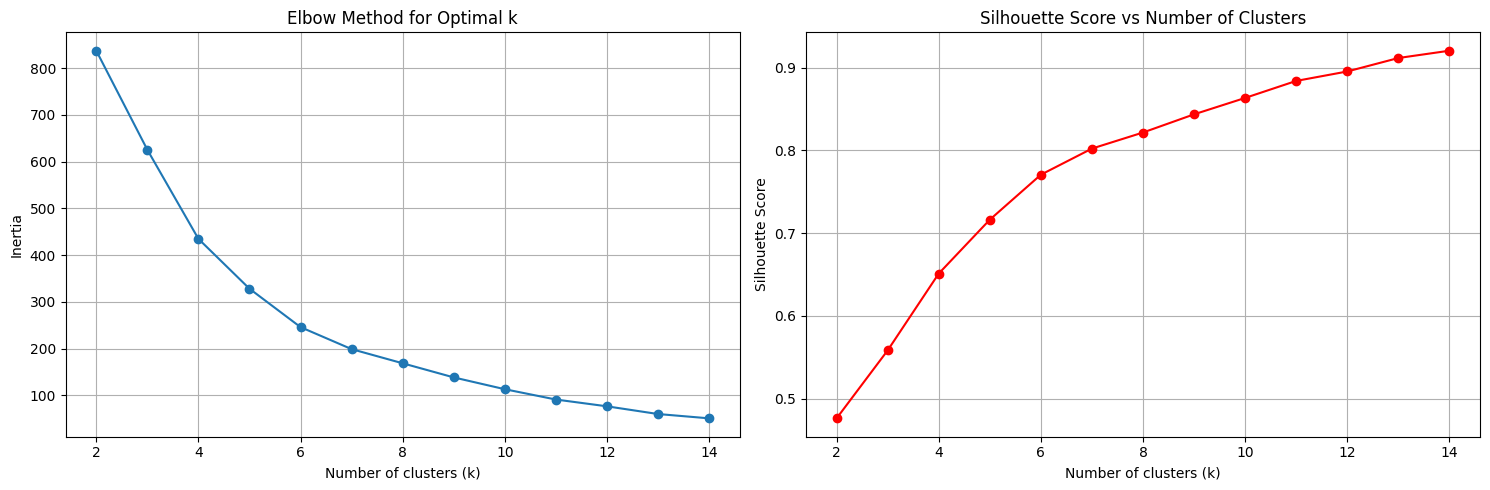

Optimal number of clusters based on silhouette score: 14
Best silhouette score: 0.921


In [638]:
# Enhanced elbow method with silhouette analysis
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
import numpy as np

RANDOM_STATE = 42

# Test different numbers of clusters
MAX_CLUSTERS = 15
K_range = range(2, MAX_CLUSTERS)
inertias = []
silhouette_scores = []

for k in K_range:
    kmeans = KMeans(n_clusters=k, random_state=RANDOM_STATE, n_init=10)
    kmeans.fit(x)
    inertias.append(kmeans.inertia_)
    silhouette_scores.append(silhouette_score(x, kmeans.labels_))

# Plot both metrics
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

# Elbow plot
ax1.plot(K_range, inertias, marker='o')
ax1.set_xlabel('Number of clusters (k)')
ax1.set_ylabel('Inertia')
ax1.set_title('Elbow Method for Optimal k')
ax1.grid(True)

# Silhouette score plot
ax2.plot(K_range, silhouette_scores, marker='o', color='red')
ax2.set_xlabel('Number of clusters (k)')
ax2.set_ylabel('Silhouette Score')
ax2.set_title('Silhouette Score vs Number of Clusters')
ax2.grid(True)

plt.tight_layout()
plt.show()

# Find optimal k based on silhouette score
optimal_k = K_range[np.argmax(silhouette_scores)]
print(f"Optimal number of clusters based on silhouette score: {optimal_k}")
print(f"Best silhouette score: {max(silhouette_scores):.3f}")

# Update N_CLUSTERS
N_CLUSTERS = 5

## Run K-means clustering

In [639]:
# Improved K-means clustering with optimized parameters
from sklearn.cluster import KMeans

# Use the optimal number of clusters found in the previous cell
print(f"Using {N_CLUSTERS} clusters for final clustering")

# Enhanced K-means with better parameters
clustering = KMeans(
    n_clusters=N_CLUSTERS, 
    random_state=RANDOM_STATE,
    n_init=20,  # Run multiple initializations
    max_iter=300,  # More iterations for convergence
)

clustering.fit(x)
labels = clustering.predict(x)
centroids = clustering.cluster_centers_

# Cluster labels
df_original['Cluster'] = clustering.labels_+1

df_original[["Id", "Cluster"]].sort_values("Cluster")

Using 5 clusters for final clustering


,Id,Cluster
997,1117,1
1399,1541,1
772,885,1
1398,1540,1
775,888,1
...,...,...
1484,1630,5
1479,1625,5
1466,1611,5
1717,1879,5


## Show the cluster sizes

In [640]:
clustersizes = df_original.groupby('Cluster')['Id'].count().reset_index()
clustersizes.rename(columns={'Id': 'Count'}, inplace=True)

clustersizes

,Cluster,Count
0,1,1037
1,2,130
2,3,343
3,4,216
4,5,270


## Calculate the silhouette score and inertia

In [641]:
from sklearn.metrics import silhouette_score
import numpy as np

group_column = df_original["Cluster"]
silhouette_avg = silhouette_score(x, group_column)

# Inertia does not exist in hierarchical algoritm in scikit, so we need to calculate it
centroids = np.array([x[group_column == i].mean(axis=0) for i in range(N_CLUSTERS)])
inertia = sum(
    np.sum(np.linalg.norm(x[group_column == i] - centroids[i], axis=1)**2)
    for i in range(N_CLUSTERS)
)

print(f"Silhouette Score: {silhouette_avg:.3f}")
print(f"Inertia: {inertia:.3f}")

Silhouette Score: 0.716
Inertia: 244.237


## Calculate the relative importance of the features

In [642]:
def calculate_importances(df, variables, cluster_col='Cluster'):
    overall_means = df[variables].mean()
    cluster_means = df.groupby(cluster_col)[variables].mean()
    cluster_sizes = df[cluster_col].value_counts()

    # Numerator: variance between clusters
    ss_between = ((cluster_means - overall_means) ** 2).multiply(cluster_sizes, axis=0).sum()

    # Denominator: total variance
    ss_total = ((df[variables] - overall_means) ** 2).sum()

    importance = (ss_between / ss_total).sort_values(ascending=False)
    return importance.to_frame(name='relative importance')


numerical_columns = [f for f in df_original.columns if is_numerical(df_original[f]) and f != 'Id']
importance_df = calculate_importances(df_original, variables=numerical_columns)
print('Numeric variable importances:', "\n")
print(importance_df)

Numeric variable importances: 

              relative importance
Outer                    1.074584
Penthouse                0.828037
Elevator                 0.127308
Rent                     0.121905
Cottage                  0.100850
Floor                    0.061976
Sq.Mt                    0.032673
Bedrooms                 0.009717
Duplex                   0.007556
Semidetached                  NaN


## Describe the clusters

In [643]:
import pandas as pd

# df_prof will store cluster averages to calculate profile and global metrics
df_prof = df_original.drop(columns="Id", axis=1).select_dtypes(include=['number'])
df_prof = df_prof.groupby("Cluster").mean().transpose()
df_prof["Average"] = df_prof.mean(axis=1)
df_prof["Std.dev"] = df_prof.std(axis=1)
df_prof

Cluster,1,2,3,4,5,Average,Std.dev
Rent,2190.910318,2643.492308,1373.594752,779.773148,1876.755556,1772.905216,646.404702
Bedrooms,2.470352,2.293651,2.544643,2.232227,2.215768,2.351328,0.132231
Sq.Mt,129.423337,146.784615,111.655977,71.847222,132.200000,118.382230,25.808067
Floor,3.710756,5.676923,3.189759,2.670984,2.690583,3.587801,1.112074
Outer,1.000000,0.952756,0.981873,0.910526,0.000000,0.769031,0.385703
Elevator,0.939981,0.953846,0.934328,0.614213,0.757848,0.840043,0.133853
Penthouse,0.000000,1.000000,0.078717,0.000000,0.000000,0.215743,0.393312
Cottage,0.000000,0.000000,0.000000,0.000000,0.114815,0.022963,0.045926
Duplex,0.027001,0.000000,0.040816,0.004630,0.007407,0.015971,0.015466
Semidetached,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000


Text(0.5, 733.2777777777777, 'Cluster')

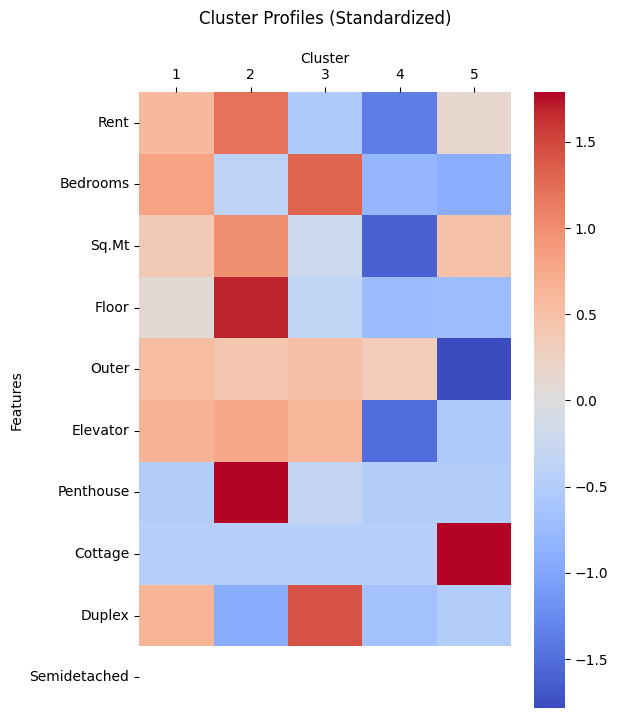

In [644]:
import seaborn as sns

# Standardize each row (z-score normalization)
# Only use the cluster columns (exclude Average and Std.dev for the heatmap)
df_prof_normalized = df_prof.iloc[:, :-2]  # Get only cluster columns

# Calculate z-scores: (value - row_mean) / row_std
df_prof_normalized = df_prof_normalized.sub(df_prof_normalized.mean(axis=1), axis=0).div(df_prof_normalized.std(axis=1), axis=0)

plt.figure(figsize=(6, 8))  
plt.gca().xaxis.set_label_position('top')
plt.gca().xaxis.tick_top()
sns.heatmap(df_prof_normalized, cmap="coolwarm", annot=False, cbar=True, center=0)
plt.title('Cluster Profiles (Standardized)', pad=20)
plt.ylabel('Features')
plt.xlabel('Cluster')

    Cluster           District  Proportion
0         1          Salamanca    0.216008
1         1             Centro    0.183221
2         1          Chamartín    0.164899
3         1             Tetuán    0.125362
4         1           Chamberí    0.121504
8         2          Salamanca    0.276923
9         2             Centro    0.200000
10        2           Chamberí    0.169231
11        2          Chamartín    0.115385
12        2            Moncloa    0.084615
20        3         Fuencarral    0.303207
21        3      Ciudad Lineal    0.265306
22        3          Hortaleza    0.215743
23        3           San Blás    0.154519
24        3            Barajas    0.061224
25        4        Carabanchel    0.226852
26        4    Puente Vallecas    0.199074
27        4             Latina    0.162037
28        4          Vicálvaro    0.129630
29        4  Villa de Vallecas    0.115741
32        5             Centro    0.233333
33        5          Salamanca    0.185185
34        5

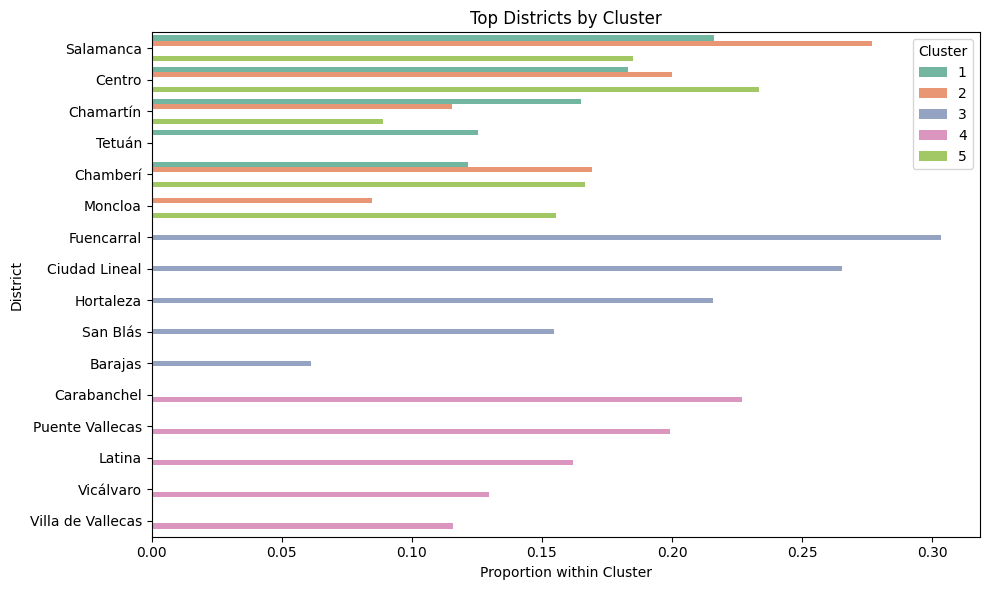

In [645]:
district_profile = (
    df_original.groupby("Cluster")["District"]
    .value_counts(normalize=True)     # percentage distribution per cluster
    .rename("Proportion")
    .reset_index()
    .sort_values(["Cluster", "Proportion"], ascending=[True, False])
)

# Show top 5 districts per cluster
top_districts = district_profile.groupby("Cluster").head(5)
print(top_districts)
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(10,6))
sns.barplot(
    data=top_districts,
    x="Proportion", y="District", hue="Cluster",
    palette="Set2"
)
plt.title("Top Districts by Cluster")
plt.xlabel("Proportion within Cluster")
plt.ylabel("District")
plt.legend(title="Cluster")
plt.tight_layout()
plt.show()

## Save the data

In [646]:
df_original.to_csv('madrid_rent_data_clustered.csv', index=False)

print("Data saved to madrid_rent_data_clustered.csv")

Data saved to madrid_rent_data_clustered.csv
